In [1]:
from data.wider_face import *
from data.preprocess import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from config import *

In [2]:
dataset = WiderFaceDataset(split = 'train')

==> initializing centerface key point train data.
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Loaded train 12671 samples


In [6]:
index = 1
# img_id = data.images[index]
# file_name = data.coco.loadImgs(ids=[img_id])[0]['file_name']

# ann_ids = data.coco.getAnnIds(imgIds=img_id)

# img = cv2.imread(os.path.join(data.img_dir, file_name))
# anns = data.coco.loadAnns(ids=ann_ids)

# len(anns)
# img_path, anns = dataset.__getitem__(index)

# img = cv2.imread(img_path)
# pts = np.array(anns[0]['keypoints'], np.float32).reshape(5, 3)
# num_kpts = pts[:, 2].sum() 

# len(anns)
# anns[0]
res = dataset.__getitem__(index)
res.keys()

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'landmarks', 'hps_mask', 'wight_mask', 'hm_offset', 'hm_hp', 'hp_offset', 'hp_ind', 'hp_mask'])

In [91]:
pts = np.array(anns[0]['keypoints'], np.float32).reshape(5, 3)
num_kpts = pts[:, 2].sum()

num_kpts 

10.0

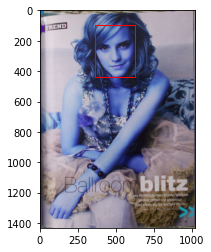

In [94]:
bbox = []

def visualize_item(index):
    img_id = dataset.images[index]
    file_name = dataset.coco.loadImgs(ids=[img_id])[0]['file_name']
    img_path = os.path.join(dataset.img_dir, file_name)
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)
    num_objs = len(anns)

    img = cv2.imread(img_path)
    
    fig, ax = plt.subplots()

    ax.imshow(img)
    
    # plt.scatter(anns[0]['keypoints'][1], anns[0]['keypoints'][0])

    # for ann in anns:
    #     # the segmentation are in format (x1, y1, x2, y2) (top left and bottom right points) 
    #     # (after convert from coco format to box format)
    #     # coco format (top left x, top left y, width, height)
    #     x1 = ann['segmentation'][0]
    #     y1 = ann['segmentation'][1]
    #     x2 = ann['segmentation'][2]
    #     y2 = ann['segmentation'][3]
    #     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    #     ax.add_patch(rect)

    ann = anns[0]
    x1 = ann['segmentation'][0]
    y1 = ann['segmentation'][1]
    x2 = ann['segmentation'][2]
    y2 = ann['segmentation'][3]

    # h, w of bbox
    bbox.append(y2 - y1)
    bbox.append(x2 - x1)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    plt.scatter(ann['keypoints'][2], ann['keypoints'][2])
    
    plt.show()

visualize_item(index)

In [58]:
def Data_anchor_sample(image, anns):
    maxSize = 12000
    infDistance = 9999999

    boxes = []
    for ann in anns:
        boxes.append([ann['bbox'][0], ann['bbox'][1], ann['bbox'][0]+ann['bbox'][2], ann['bbox'][1]+ann['bbox'][3]])
    boxes = np.asarray(boxes, dtype=np.float32)

    height, width, _ = image.shape

    random_counter = 0

    boxArea = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    rand_idx = random.randint(0, len(boxArea)-1)
    rand_Side = boxArea[rand_idx] ** 0.5

    anchors = [16, 32, 48, 64, 96, 128, 256, 512]
    distance = infDistance
    anchor_idx = 5
    for i, anchor in enumerate(anchors):
        if abs(anchor - rand_Side) < distance:
            distance = abs(anchor - rand_Side)  # 选择最接近的anchors       Choose the closet anchor
            anchor_idx = i

    target_anchor = random.choice(anchors[0:min(anchor_idx+1, 5) ])  # 随机选择一个相对较小的anchor，向下       Randomly select a relatively small anchor, down
    ratio = float(target_anchor) / rand_Side  # 缩放的尺度      Scale of scaling
    ratio = ratio * (2 ** random.uniform(-1, 1))  # [ratio/2, 2ratio]的均匀分布     Uniform distribution

    if int(height * ratio * width * ratio) > maxSize * maxSize:
        ratio = (maxSize * maxSize / (height * width)) ** 0.5

    interp_methods = [cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_NEAREST, cv2.INTER_LANCZOS4]
    interp_method = random.choice(interp_methods)
    image = cv2.resize(image, None, None, fx=ratio, fy=ratio, interpolation=interp_method)

    boxes[:, 0] *= ratio
    boxes[:, 1] *= ratio
    boxes[:, 2] *= ratio
    boxes[:, 3] *= ratio

    boxes = boxes.tolist()
    for i in range(len(anns)):
        anns[i]['bbox'] = [boxes[i][0], boxes[i][1], boxes[i][2]-boxes[i][0], boxes[i][3]-boxes[i][1]]      # 人脸bbox   face bboxes
        for j in range(5):
            anns[i]['keypoints'][j*3] *= ratio
            anns[i]['keypoints'][j*3+1] *= ratio

    return image, anns

In [12]:
new_img, new_anns = Data_anchor_sample(img, anns)

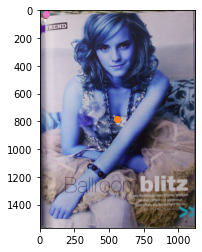

In [87]:
# def visualize(img, anns):
#     plt.imshow(img)
#     for i in range(0, len(anns)):
#         kpts = anns[i]['keypoints']
#         bbox = anns[i]['bbox']
#         plt.scatter(bbox[0], bbox[1])
#         plt.scatter(img.shape[1]/2, img.shape[0]/2)
#         plt.scatter(kpts[0], kpts[1])
#         plt.scatter(kpts[3], kpts[4])
#         plt.scatter(kpts[6], kpts[7])
#         plt.scatter(kpts[9], kpts[10])
#         plt.scatter(kpts[12], kpts[13])

# visualize(new_img, new_anns)

In [93]:
def gaussian_radius(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 + sq1) / 2

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 + sq2) / 2

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / 2
  return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1                                         # 直径
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]         # 对那个区域进行赋值   Assign a value to that area
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap

def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap


def draw_msra_gaussian(heatmap, center, sigma):
  tmp_size = sigma * 3
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

In [97]:
h, w = bbox
center = [w/2, h/2]
radius = gaussian_radius(det_size=bbox)
draw_umich_gaussian(radius, center, )


81.0637698381845

In [16]:
c = np.array([new_img.shape[1] / 2., new_img.shape[0] / 2.], dtype=np.float32)
s = max(new_img.shape[0], new_img.shape[1]) * 1.0
rot = 0
print(c, s)

[560.5 784. ] 1568.0


In [17]:
output_res = 200
bboxes = []
points = []
landmarks = []
num_joints = 5


trans_inp = get_affine_transform(c, s, rot, [INPUT_SIZE, INPUT_SIZE])
inp = cv2.warpAffine(img, trans_inp, 
                         (INPUT_SIZE, INPUT_SIZE),
                         flags=cv2.INTER_LINEAR)

trans_output_rot = get_affine_transform(c, s, rot, [output_res, output_res])
trans_output = get_affine_transform(c, s, 0, [output_res, output_res])

for ann in new_anns:
    bbox = data._coco_box_to_bbox(ann['bbox'])
    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox = np.clip(bbox, 0, output_res - 1)
    bboxes.append(bbox)

    pts = np.array(ann['keypoints'], np.float32).reshape(num_joints, 3)
    points.append(pts)

    lm = np.array(ann['keypoints'], np.float32)
    landmarks.append(lm)

print(bboxes)
    

AttributeError: module 'torch.utils.data' has no attribute '_coco_box_to_bbox'

In [120]:
original_boxes = []
for ann in new_anns:
    bbox = data._coco_box_to_bbox(ann['bbox'])
    # bbox[:2] = affine_transform(bbox[:2], trans_output)
    # bbox[2:] = affine_transform(bbox[2:], trans_output)
    # bbox = np.clip(bbox, 0, output_res - 1)
    original_boxes.append(bbox)

print(original_boxes)

[array([136.62703, 177.61513, 150.91077, 199.35126], dtype=float32), array([231.64491, 204.3195 , 243.44452, 219.22427], dtype=float32), array([357.09335, 178.23616, 368.89297, 193.14093], dtype=float32), array([432.85925, 232.26595, 440.93268, 244.06555], dtype=float32), array([396.83942, 227.91872, 403.67075, 239.71832], dtype=float32)]


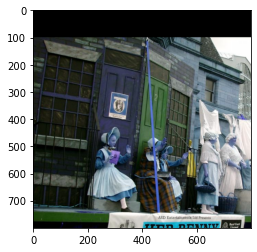

In [121]:
plt.imshow(inp)
# num_kpts = pts[:, 2].sum()  

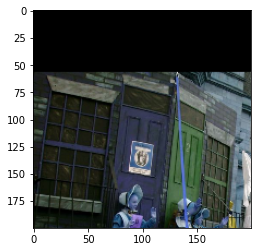

In [122]:
out = cv2.warpAffine(inp, trans_output, 
                         (OUTPUT_SIZE, OUTPUT_SIZE),
                         flags=cv2.INTER_LINEAR)

plt.imshow(out)

In [123]:
from data.augment import *

In [124]:
color_aug(data._data_rng, inp, data._eig_val, data._eig_vec)

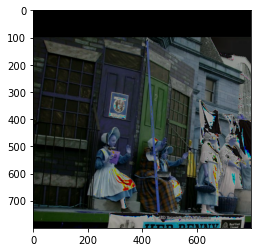

In [125]:
plt.imshow(inp)

In [80]:
w = 10
h = 8
wh = np.zeros((5, 2), dtype=np.float32)  # max objects x 2 
wh[0] = np.log(1. * w / 4), np.log(1. * h / 4) 

wh

array([[0.91629076, 0.6931472 ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]], dtype=float32)

In [79]:
np.log(1.)

0.0